In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent

('2017-08-23')

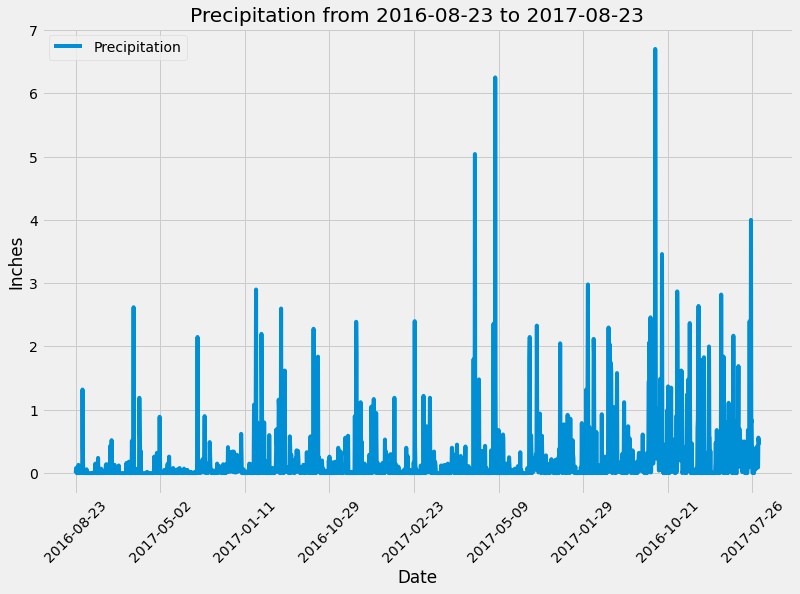

<Figure size 432x288 with 0 Axes>

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent[0], '%Y-%m-%d')
one_year = dt.date(recent_date.year-1, recent_date.month, recent_date.day)
one_year

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date,measurement.prcp).filter(measurement.date >= one_year).all()
query

# Save the query results as a Pandas DataFrame and set the index to the date column
p_data = pd.DataFrame(query, columns=['Date','Precipitation'])
p_data.set_index('Date', inplace=True)

# Sort the dataframe by date
p_data.dropna(how='any',inplace=True)
p_data.sort_values(['Date'], ascending=True)

p_data.head()

# Use Pandas Plotting with Matplotlib to plot the data
p_data.plot(figsize=(12,8), rot=45)
plt.title(f'Precipitation from {one_year} to {recent[0]}')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='best')
plt.show()
plt.savefig('Images/Precipitation_Plot.png')

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
p_data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
activeness = pd.DataFrame(most_active, columns = ['Station', 'Count'])
most_active_station = activeness.iloc[0,0]

mas_low = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_station).all()
mas_high = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_station).all()
mas_avg = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station).all()

print(f'Most active station:{most_active_station}')
print(f'Lowest temp:{mas_low}')
print(f'Highest temp:{mas_high}')
print(f'Average temp:{mas_avg}')

Most active station:USC00519281
Lowest temp:[(54.0,)]
Highest temp:[(85.0,)]
Average temp:[(71.66378066378067,)]


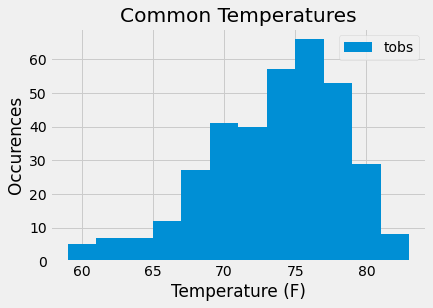

<Figure size 432x288 with 0 Axes>

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_year_query = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year).\
    order_by(measurement.date.asc()).all()

past_year_data = pd.DataFrame(past_year_query)
past_year_data

# Makin history... gram
past_year_data.plot.hist(bins=12)
plt.title('Common Temperatures')
plt.xlabel('Temperature (F)')
plt.ylabel('Occurences')
plt.legend(loc='best')
plt.show()
plt.savefig("Images/Temperature_Plot.png")

# Close session

In [18]:
# Close Session
session.close()